## Skin Cancer Binary Classification CNN HOTARU v1.1

The following notebook displays how the second version of the CNN model for skin cancer identification HOTARU was made.

The aim of this CNN model is to determine whether a photo provided by an enduser displays signs of skin cancer. It does not aim to identify what kind of skin cancer it is, but rather determines the presence of skin cancer.

This model is one half of the identification program. HOTARU v1.1 is accompanied by SPARK v1.0, an accompanying image preprocessing script that aims to make HOTARU's predictions more accurate by removing unnecessary features like healthy skin and body hair in an image before the image is fed into the model for prediction.

This model consists of a CNN section encapsulated into a Sequential object, which ends with an output layer that displays a value between 0 and 1. The closer it is to 0, the more convinced the model is that the photo does not show skin cancer, and vice versa (1 being indicating skin cancer).

**Changes done**
- Adjusted epoch from 20 to 10
- Removed input and resizing layer due to preprocessing script already taking care of that.
- In exchange, the CNN now has a input size parameter.
- Retraining model with preprocessed data instead of raw data.

In [20]:
# Importing relevant packages
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, RandomContrast
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage import io, color, exposure
from skimage.filters import threshold_otsu

In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Defining datasets, which are already preprocessed prior to feeding to model
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/train', image_size=(300,300), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/val', image_size=(300,300), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/test', image_size=(300,300), batch_size=32)

Found 47969 files belonging to 2 classes.
Found 3993 files belonging to 2 classes.
Found 1334 files belonging to 2 classes.


# Creating the CNN part of the model

In [4]:
# Creating Sequential object
cnn = Sequential()

In [5]:
# Adding layers to Sequential object
cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(300,300,3))) # Input layer of CNN
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(16, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(1, activation='sigmoid')) # Output layer of CNN, only producing a value between 0 and 1

In [6]:
# Compiling the CNN
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [7]:
# Summary of the CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 16)        0

# Logging

In [8]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training

In [9]:
hist = cnn.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/10


1500/1500 [==============================] - 418s 276ms/step - loss: 0.2403 - accuracy: 0.9207 - precision: 0.9327 - recall: 0.9598 - val_loss: 0.1582 - val_accuracy: 0.9376 - val_precision: 0.9534 - val_recall: 0.9609
Epoch 2/10
1500/1500 [==============================] - 376s 251ms/step - loss: 0.0579 - accuracy: 0.9786 - precision: 0.9850 - recall: 0.9854 - val_loss: 0.2051 - val_accuracy: 0.9504 - val_precision: 0.9591 - val_recall: 0.9730
Epoch 3/10
1500/1500 [==============================] - 376s 251ms/step - loss: 0.0261 - accuracy: 0.9915 - precision: 0.9945 - recall: 0.9937 - val_loss: 0.2516 - val_accuracy: 0.9464 - val_precision: 0.9506 - val_recall: 0.9768
Epoch 4/10
1500/1500 [==============================] - 374s 250ms/step - loss: 0.0216 - accuracy: 0.9930 - precision: 0.9953 - recall: 0.9950 - val_loss: 0.3362 - val_accuracy: 0.9514 - val_precision: 0.9530 - val_recall: 0.9813
Epoch 5/10
1500/1500 [==============================] - 394s 263ms/step - loss

# Evaluation

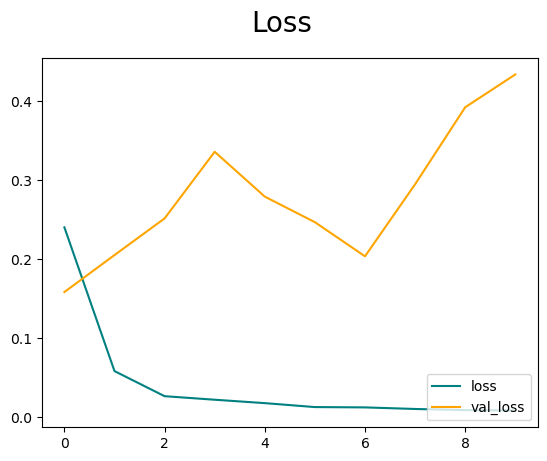

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="lower right")
plt.show()

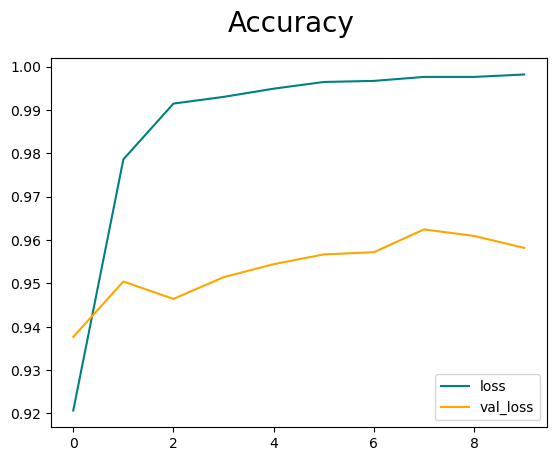

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

# Testing with a batch

In [12]:
# Evaluating the model using the prediction dataset
model_loss, model_accuracy = cnn.evaluate(test_dataset,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

42/42 - 3s - loss: 0.3760 - accuracy: 0.9715 - precision: 0.9716 - recall: 0.9897 - 3s/epoch - 83ms/step


ValueError: too many values to unpack (expected 2)

**Result**

Accuracy of 97.2%, with precision of 97.2% and recall of 98.9%. 42 photos from both classes were used. Processing took 3 seconds.

This version of the skin cancer detection CNN model nearly predicted all photos provided in the test dataset accurately, which is a big improvement over the previous version of the model (80% accuracy). Similarly, precision improved significantly when compared to the previous version of the model. However, recall took a bit of a hit, suffering a 1.1% decrease; this means that there is a rare chance for false positives.

Furthermore, the removal of the preprocessing stage of the model significantly decreased the time taken to complete an epoch (7 minutes as opposed to 16 minutes).

Moreover, the introduction of preprocessed image data instead of raw data may have a role in the improvement of accuracy and/or training speed in this model. While the preprocessing script made for this version of the model is not very optimal (it still introduces unnecessary features like body hair and sometimes removes the important features altogether), it is clear that some form of preprocessing is better than no preprocessing.

# Testing with a single picture / Showcasing preprocessing script

In [23]:
# Creating preprocessing function
def prepro(img_path, cmap_type='gray'):
    # Loading in image
    img = Image.open(img_path)
    
    # Resize the image to a consistent size (e.g., 224x224)
    img = img.resize((300, 300))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Saving original array for comparison purposes
    img_ori = img_array
    
    # Normalize pixel values to be between 0 and 1
    img_array = img_array.astype('float32') / 299

    # Converting RGB picture to greyscale for thresholding
    img_gc = color.rgb2gray(img_array)

    # Adjusting exposure
    img_ex1 = exposure.adjust_log(img_gc)

    p2, p98 = np.percentile(img_ex1, (2, 98))
    img_ex2 = exposure.rescale_intensity(img_ex1, in_range=(p2, p98))

    # Global thresholding with Otsu
    thresh = threshold_otsu(img_ex2)
    
    # Creating threshold image
    img_t = img_ex2 <= thresh

    # Creating mask using threshold image
    # Value 0 as black and white photo used
    mask = np.where(img_t >= 0, img_t, 0)

    # Overlaying mask on original image
    # So that model will receive only skinmark (the less pixels to consider, the faster processing becomes)
    
    # Nested for loop for each 'row' of img
    for h in range(mask.shape[0]):
      # For each 'column' of img
        for w in range(mask.shape[1]):
          # If the pixel chosen from the mask is white, add in the pixel from the original image
          # Otherwise, discard/make pixel black
            if mask[h][w] == 0:
                for i in range(3):
                    img_array[h][w][i] = 0
            else:
                continue

    # Show original and preprocessed photo side by side
    plt.subplot(1, 2, 1)
    plt.imshow(img_ori, cmap=cmap_type)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap=cmap_type)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_array

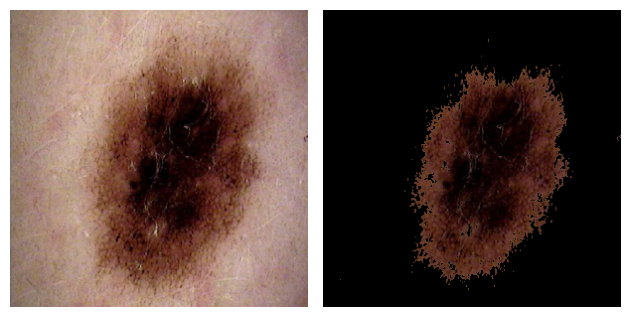

In [24]:
# Feeding model with a photo with a ground truth of having skin cancer

# Preprocessing image
img1 = prepro("predict/ISIC_1197584.JPG")

In [26]:
# Model prediction
pred1 = cnn.predict(np.expand_dims(img1/255, 0))

pred1

1/1 [==============================] - 0s 105ms/step


array([[0.00021455]], dtype=float32)

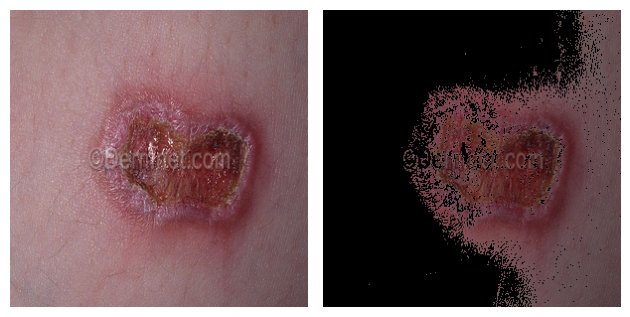

In [27]:
# Feeding model with a photo with a ground truth of NOT having skin cancer

# Preprocessing image
img2 = prepro("predict/pyoderma-gangrenosum-19.jpg")

In [28]:
# Model prediction
pred2 = cnn.predict(np.expand_dims(img2/255, 0))

pred2

1/1 [==============================] - 0s 22ms/step


array([[0.00022522]], dtype=float32)

**Results**

Did not correctly identify skin cancer image, but correctly identified non-skin cancer image.

## Saving the model

In [30]:
# Export our model to HDF5 file
cnn.save("models/prod_2.h5")

C:\Users\dalet\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Exporting model as Pickle file
import pickle

pickle.dump(cnn, open('models/prod_2.pkl', 'wb'))

**Moving forward** 

- Improve on preprocessing script to be more accurate in determining important features.